In [1]:
import torch
import os
import glob
import pickle

if 'DISPLAY' in os.environ:
    del os.environ['DISPLAY']
    
user_env = os.environ['USER']
job_env = os.environ['SLURM_JOB_ID']
import sys
sys.path.append('../externals/hnn-core')
sys.path.append('../../externals/hnn-core')
sys.path.append('../code')
from tqdm import tqdm
from torch import optim
import numpy as np
import datetime
from pathlib import Path
from utils import (load_prerun_simulations, filter_borders, filter_nzeros, filter_peakproeminence,
                   filter_removeoutliers, filter_peaktime, linear_scale_forward, simulator_hnn,
                   UniformPrior, PriorBetaFiltered, build_flow, hnn_beta_param_function,
                   linear_scale_array, load_posterior)
from functools import partial
import joblib
from distributed import Client
from dask_jobqueue import SLURMCluster
import dask
from joblib import Parallel, delayed
import datetime
import dask.bag as db
from sbi import inference as sbi_inference
from hnn_core import calcium_model, jones_2009_model
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import dill
import pandas as pd
import seaborn as sns
sns.set()
sns.set_style("white")

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


In [2]:
data_path = '../data'

with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
    

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)

dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples']

dpl_orig, theta_orig = np.load(f'{data_path}/sbi_sims/dpl_sbi_1.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi_1.npy')
dpl_orig = dpl_orig[:,window_samples[0]:window_samples[1]]

net = jones_2009_model()

simulator = partial(simulator_hnn, prior_dict=prior_dict, param_function=hnn_beta_param_function,
                    network_model=net, tstop=tstop, return_objects=True)

In [3]:
with open(f'{data_path}/flows/prior_filtered_flow_1.pkl', 'rb') as output_file:
    state_dict = dill.load(output_file)

prior = PriorBetaFiltered(parameters=list(prior_dict.keys()))
prior.flow.load_state_dict(state_dict)

<All keys matched successfully>

In [4]:
filters = [filter_borders, filter_nzeros, filter_peakproeminence, filter_peaktime, filter_removeoutliers]
# Filter simulations
dpl_filter, theta_filter = dpl_orig, theta_orig
for filter_func in filters:
    dpl_filter, theta_filter = filter_func(dpl_filter, theta_filter)

In [5]:
prior_filtered = PriorBetaFiltered(parameters=list(prior_dict.keys()))
optimizer = optim.Adam(prior_filtered.flow.parameters())

num_iter = 5000
for i in tqdm(range(num_iter)):
    optimizer.zero_grad()
    loss = -prior_filtered.flow.log_prob(inputs=theta_filter).mean()
    loss.backward()
    optimizer.step()
state_dict = prior_filtered.flow.state_dict()

100%|██████████| 5000/5000 [01:13<00:00, 68.04it/s]


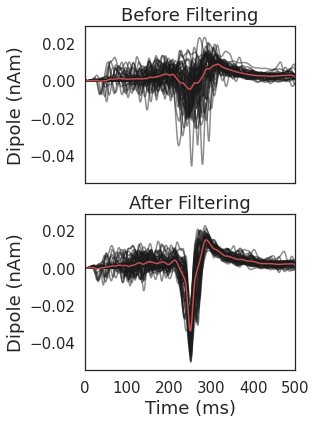

In [61]:
%matplotlib inline
labelsize = 18
titlesize = 18
ticksize = 15
alpha=0.5
ylim = [-0.055, 0.029]
xlim = [0, 500]
xtimes = np.linspace(0, 500, dpl_filter.shape[1])

plt.figure(figsize=(4.5,6))
plt.subplot(2,1,1)
orig_plot_data = dpl_orig[:50,:]
_ = plt.plot(xtimes, orig_plot_data.T, color='k', alpha=alpha)
plt.plot(xtimes, np.mean(orig_plot_data, axis=0), color='r')
plt.xticks([])
_ = plt.yticks(size=ticksize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('Before Filtering', size=titlesize)


plt.subplot(2,1,2)
filtered_plot_data = dpl_filter[:50,:]
_ = plt.plot(xtimes, filtered_plot_data.T, color='k', alpha=alpha)
plt.plot(xtimes, np.mean(filtered_plot_data, axis=0), color='r')
_ = plt.xticks(size=ticksize)
_ = plt.yticks(size=ticksize)
plt.xlabel('Time (ms)', size=labelsize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.ylim(ylim)
plt.xlim(xlim)
plt.title('After Filtering', size=titlesize)

plt.tight_layout()
plt.savefig('../figures/beta_filter.svg')

In [32]:
num_sims = 1000
theta_samples = prior_filtered.sample((num_sims,))

In [33]:
_ = prior.flow.eval()

In [34]:
cond_idx = 1

input_type_list = list(posterior_state_dicts.keys())
input_type = input_type_list[0]
print(input_type)

posterior_dict = posterior_state_dicts[input_type]
state_dict = posterior_dict['posterior']
n_params = posterior_dict['n_params']
n_sims = posterior_dict['n_sims']
input_dict = posterior_dict['input_dict']

embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])

num_samples = 1000
all_labels = list(prior_dict.keys())
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

load_info = {'x_train': posterior_dict['input_dict']['feature_func'](dpl_orig), 
                 'x_cond': posterior_dict['input_dict']['feature_func'](dpl_filter[cond_idx,:].reshape(1,-1))}

posterior = load_posterior(state_dict=state_dict,
                               x_infer=torch.tensor(load_info['x_train'][:10,:]).float(),
                               theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

posterior_samples = posterior.sample((num_samples,), x=torch.tensor(load_info['x_cond']))


pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [35]:
theta_samples_transformed = linear_scale_array(theta_samples.numpy(), all_bounds)
theta_df_dict = {name: theta_samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
theta_df = pd.DataFrame(theta_df_dict)
theta_df = theta_df.iloc[:, 4:]

theta_cond_transformed = linear_scale_array(theta_filter[cond_idx, :].reshape(1,-1), all_bounds).squeeze()

posterior_samples_transformed = linear_scale_array(posterior_samples.numpy(), all_bounds, constrain_value=False)
posterior_df_dict = {name: posterior_samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
posterior_df = pd.DataFrame(posterior_df_dict)
posterior_df = posterior_df.iloc[:, 4:]


In [36]:
df = pd.concat([theta_df, posterior_df])
df['cond'] = np.concatenate([np.repeat('Prior', num_samples), np.repeat('Posterior', num_samples)])

In [37]:
tick_dict = dict()
nval_samples = 10
for p_idx, param_dict in enumerate(prior_dict.values()):
    bounds = param_dict['bounds']
    ticks = np.round(np.linspace(bounds[0], bounds[1], nval_samples), decimals=2)
    tick_dict[f'p{p_idx}_tick_pos'] = ticks
    
    ticks = ticks.astype(str)
    ticks[1:-1] = np.repeat('', nval_samples-2)
    tick_dict[f'p{p_idx}_tick_labels'] = ticks

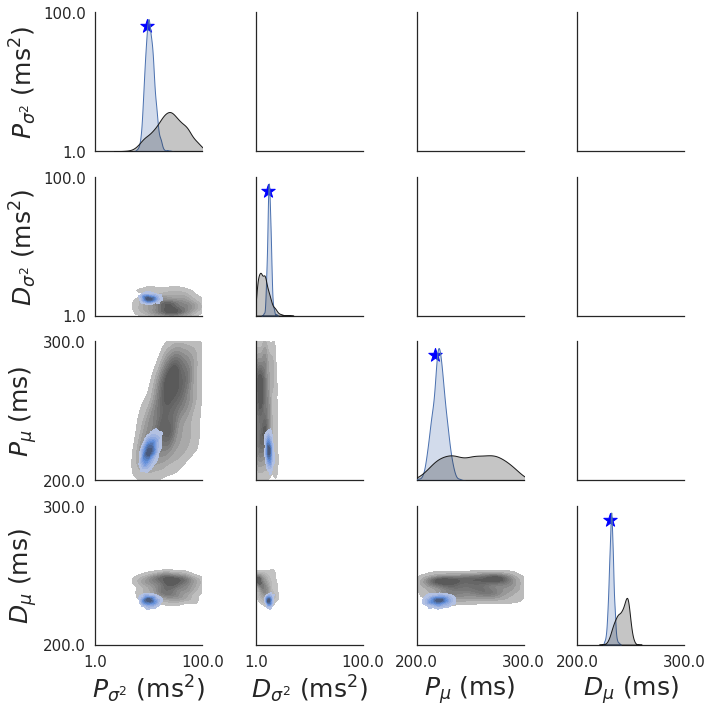

In [44]:
%matplotlib inline
labelsize=25
ticksize=15

param_labels = ['$P_{\sigma^2}$ ($\mathrm{ms}^2$)', '$D_{\sigma^2}$ ($\mathrm{ms}^2$)', '$P_\mu$ (ms)', '$D_\mu$ (ms)']

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()][4:]
g = sns.PairGrid(df, diag_sharey=False, corner=False, hue='cond', palette=['k', 'C0'])
g.map_lower(sns.kdeplot, fill=True, common_norm=False)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(4):
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])
    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])

    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[3,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

            
    g.axes[idx, 0].set_yticks(tick_dict[f'p{idx+4}_tick_pos'])
    g.axes[3, idx].set_xticks(tick_dict[f'p{idx+4}_tick_pos'])
    g.axes[idx, 0].set_yticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
    g.axes[3, idx].set_xticklabels(tick_dict[f'p{idx+4}_tick_labels'], fontsize=ticksize, rotation=0)
    
    g.axes[idx,idx].scatter(theta_cond_transformed[idx+4], all_bounds[idx][1] - y_diff*0.1,
                            color='blue', marker='*', s=200)
    
plt.tight_layout()
plt.savefig('../figures/filtered_distribution.svg')

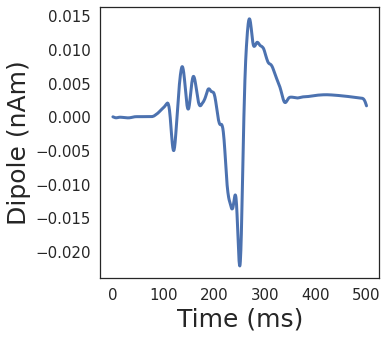

In [56]:
plt.figure(figsize=(5,5))
plt.plot(xtimes, dpl_filter[cond_idx,:], color='C0', linewidth=3)
_ = plt.xticks(size=ticksize)
_ = plt.yticks(size=ticksize)
plt.xlabel('Time (ms)', size=labelsize)
plt.ylabel('Dipole (nAm)', size=labelsize)
plt.savefig('../figures/cond_dipole.svg')